In [1]:
import insightface
import urllib
import urllib.request
import cv2
import math
import numpy as np
from numpy import linalg
from matplotlib import pyplot as plt

In [63]:
cosine_threshold = 0.4
color = (0, 0, 255)
ctx_id = 0
font = cv2.FONT_HERSHEY_SIMPLEX

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [64]:
model = insightface.app.FaceAnalysis()
model.prepare(ctx_id = ctx_id, nms=0.4)

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


In [89]:
# im = cv2.imread('test_headpose.png')
# im = cv2.imread('george.jpg')
im = cv2.imread('test_template.png')

size = im.shape

In [66]:
faces = model.get(im)

In [67]:
landmark = faces[0].landmark.astype(np.int).flatten()
bbox = faces[0].bbox.astype(np.int).flatten()
print(landmark)

[38 30 58 30 48 41 41 53 56 52]


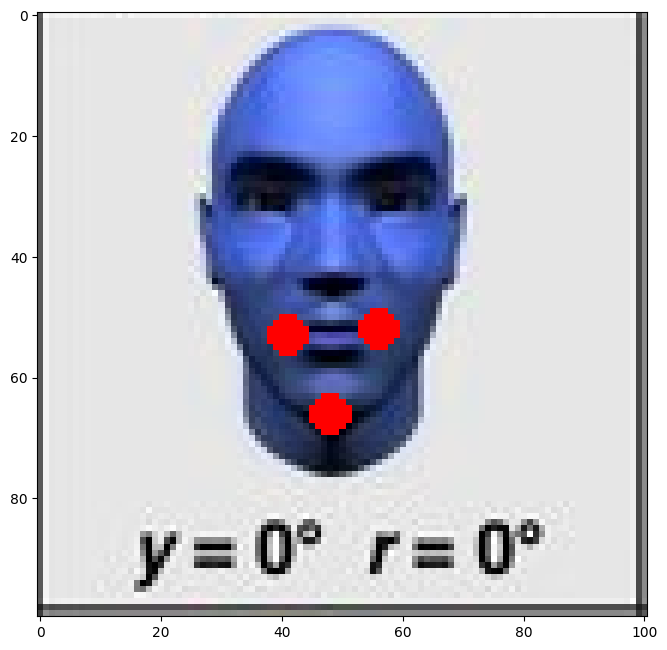

In [68]:
def chin_calc(bbox, landmarks):
    p1 = np.asarray([bbox[2], bbox[3]])
    p2 = np.asarray([bbox[0], bbox[3]])
    p3 = np.asarray([int((landmark[6] + landmark[8]) / 2), int((landmark[7] + landmark[9]) / 2)])
    
    chindistfromp3 = int(linalg.norm(np.cross(p2 - p1, p1 - p3)) / linalg.norm(p2 - p1))
    
    chin = [p3[0], p3[1] + chindistfromp3]
    
    return chin

#cv2.circle(im, (landmark[0], landmark[1]), 2, (255, 0, 0), 2)
#cv2.circle(im, (landmark[2], landmark[3]), 2, (255, 0, 0), 2)
#cv2.circle(im, (landmark[4], landmark[5]), 2, (255, 0, 0), 2)
cv2.circle(im, (landmark[6], landmark[7]), 2, (255, 0, 0), 2)
cv2.circle(im, (landmark[8], landmark[9]), 2, (255, 0, 0), 2)

chin = chin_calc(bbox, landmark)
cv2.circle(im, (chin[0], chin[1]), 2, (255, 0, 0), 2)
#cv2.rectangle(im, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)


plt.imshow(im)

In [84]:
image_points = np.array([
                            (landmark[4], landmark[5]),     # Nose tip
                            (chin[0], chin[1])        ,     # Chin
                            (landmark[0], landmark[1]),     # Left eye left corner
                            (landmark[2], landmark[3]),     # Right eye right corne
                            (landmark[6], landmark[7]),     # Left Mouth corner
                            (landmark[8], landmark[9])      # Right mouth corner
                        ], dtype="double")

# 3D model points.
model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-210.0, 170.0, -135.0),     # Left eye left corner
                            (210.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner
                        
                        ])

In [85]:
# Camera internals

focal_length = size[1]
center = (size[1]/2, size[0]/2)
camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )

print('Camera Matrix :\n {0}'.format(camera_matrix))

Camera Matrix :
 [[101.    0.   50.5]
 [  0.  101.   50. ]
 [  0.    0.    1. ]]


In [86]:
dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.cv2.SOLVEPNP_ITERATIVE)

print("Rotation Vector:\n {0}".format(rotation_vector))
print("Translation Vector:\n {0}".format(translation_vector))

Rotation Vector:
 [[0.07760848]
 [2.41943672]
 [0.07341663]]
Translation Vector:
 [[   93.64587248]
 [  117.20613408]
 [-1565.06442908]]


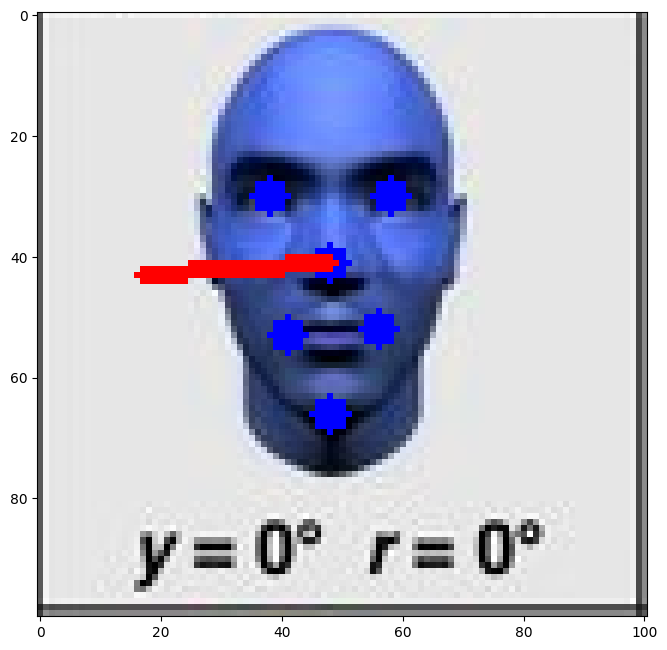

In [90]:
(nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)

for p in image_points:
    cv2.circle(im, (int(p[0]), int(p[1])), 3, (0,0,255), -1)


p1 = ( int(image_points[0][0]), int(image_points[0][1]))
p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))

cv2.line(im, p1, p2, (255,0,0), 2)

plt.imshow(im)


In [88]:
def is_rotation_matrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

def rotation_vector_to_euler_angles(rotation_vector) :
    R, _ = cv2.Rodrigues(rotation_vector)
    
    if not is_rotation_matrix(R):
        return
    
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6

    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0

    return np.rad2deg(np.array([x, y, z]))

# print(isRotationMatrix(rotation_matrix))
print(rotation_vector_to_euler_angles(rotation_vector))

[174.35359384  41.06307477 174.20937602]
